## Homework #4. Exploratory Data Analysis



#### Author: `Maria Cherkasova`\,
#### Total time spent on h/w (in minutes): `1440`

#### imports

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install langdetect

In [3]:
# !pip install deeppavlov transformers torch

In [2]:
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json
from nltk.stem import WordNetLemmatizer
from collections import Counter
from itertools import islice
from langdetect import detect, DetectorFactory, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from deeppavlov import configs, build_model

## importing data


In [8]:
df_msg_path = "/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data_upd/df_msg.csv"
df_meta_path = "/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data_upd/df_meta_upd_3.csv"

In [11]:
df = pd.read_csv(df_msg_path)
df_meta = pd.read_csv(df_meta_path)

In [12]:
df = df.drop('Unnamed: 0', axis=1)
df_meta = df_meta.drop('Unnamed: 0', axis=1)

In [15]:
df.shape

(1120638, 11)

In [16]:
df.dtypes

,0
id,int64
date,object
from_id,float64
to_id,int64
fwd_from,object
message,object
type,object
duration,float64
reactions,object
dialog_id,int64


In [18]:
df_meta.shape

(6644, 5)

In [19]:
df_meta.dtypes

,0
dialog_id,int64
name,object
type,object
users,object
full_name,object


## disclaimer

Since this is my personal data, it reflects how I communicate w my friends, classmates etc. \
Therefore, during the work and even in some analyses you can come across cuss words or sth like that. \
Hope this won't make any problems!

## to-do list

*Here I'm gonna give a quick review on analysis I'm gonna do, what graphs I wanna do and what questions I'm gonna figure out.*

1. Most active days of the week +
2. Most active hours of the day +
3. Hours of sleep +
4. Most common people, which messages were forwarded +
5. Distribution of forwarded messages over the time +
6. Types of forwarded messages +
7. People I texted to the most at the begining of full-scale invasion +
8. Most common emojis +
9. Number of people who hide vs unide their phone number +
10. Number of private messages I received on holidays (which i celebrate) +
11. Is there any difference in activity during exams period +
12. How my activity changes depending on year season +
13. My mom is quite sensitive to air alarms so she sends me lots of posts from news' channels every time, I wanna find out which channels she reads most +
14. Average length of message +
15. Average duration of conversation +
16. Most common words I use/I receive +
17. Most common phrases I use/I receive +
18. Most common reactions +
19. TF-IDF analysis+
20. Sentimental analysis +
21. Most common cuss word I use and in which period its number increases (maybe) +

- I wanna build graph that shows how many times I'm connected with my friends by group, for example, 1 group, where's me and another person, is 1 connection



## data analysis

### most active days during the week

In [20]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = pd.to_datetime(df['day'])
df['week_day'] = df['day'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year

<ipython-input-20-74232c848cf4>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')


In [21]:
# all personal chats' id
prs_id = df_meta[df_meta['type'] == 'Private dialog']['dialog_id']
# all personal messages sent
prs_sent = df[(df['from_id'] == 491709231) & (df['dialog_id'].isin(prs_id))]

# all personal messages received
prs_rcv = df[(df['to_id'] == 491709231) & (df['dialog_id'].isin(prs_id))]

In [22]:
day_order = ["Sunday", "Saturday", "Friday", "Thursday",
             "Wednesday", "Tuesday", "Monday"]

prs_s_day = prs_sent.groupby('week_day').size()
prs_s_day = prs_s_day.reindex(day_order)

prs_r_day = prs_rcv.groupby('week_day').size()
prs_r_day = prs_r_day.reindex(day_order)

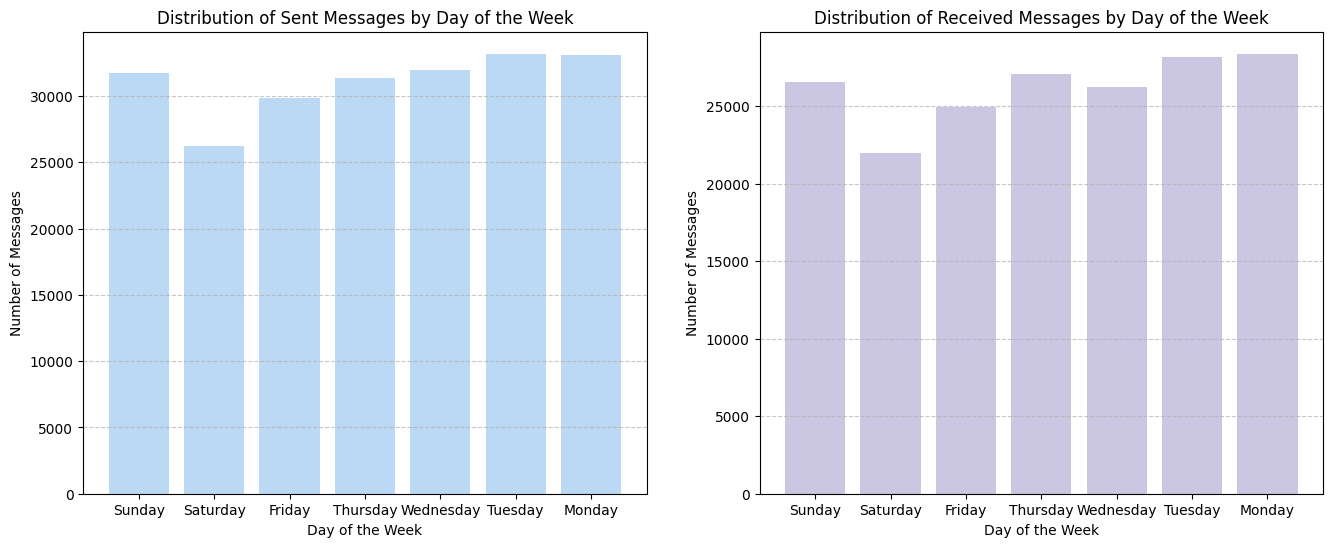

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# sent
axs[0].bar(prs_s_day.index, prs_s_day.values, color='#aacff2', alpha=0.8)
axs[0].set_title('Distribution of Sent Messages by Day of the Week')
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Number of Messages')
axs[0].tick_params(axis='x')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# received
axs[1].bar(prs_r_day.index, prs_r_day.values, color='#bfb8da', alpha=0.8)
axs[1].set_title('Distribution of Received Messages by Day of the Week')
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Number of Messages')
axs[1].tick_params(axis='y')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

As we can see, there's no big difference in percentages in the sent messages distribution, \
but still the percentages of messages sent on Monday and Tuesday are slightly higher. \

And in the received messages distribution Monday and Tuesday are also most active days.

### most active hours during the day

In [24]:
prs_s_h = prs_sent.groupby('hour').size().reset_index(name='message_count')
total = prs_s_h['message_count'].sum()
top_5_h = prs_s_h.nlargest(5, 'message_count')
top_5_h['percent'] = (top_5_h['message_count'] / total) * 100
top_5_h['percent'] = top_5_h['percent'].apply(lambda x: f"{x:.2f}%")

In [25]:
# basically the way i'm doing bins implies that this hour range includes edges
# for example, 00:00-04:00 means from 00:00 till 04:00, not from 00:00 till 03:00

bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['00:00-04:00', '04:00-08:00', '08:00-12:00',
          '12:00-16:00', '16:00-20:00', '20:00-00:00']

prs_s_h['hour_range'] = pd.cut(prs_s_h['hour'], bins=bins, labels=labels, right=False)
msg_h_range = prs_s_h.groupby('hour_range')['message_count'].sum().reset_index()

<ipython-input-25-fbaf44cae9df>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  msg_h_range = prs_s_h.groupby('hour_range')['message_count'].sum().reset_index()


In [26]:
colors = ['#75ace0', '#aacff2', '#e8b7d4', '#bfb8da',
          '#a5678e', '#8174b3', '#33539e']

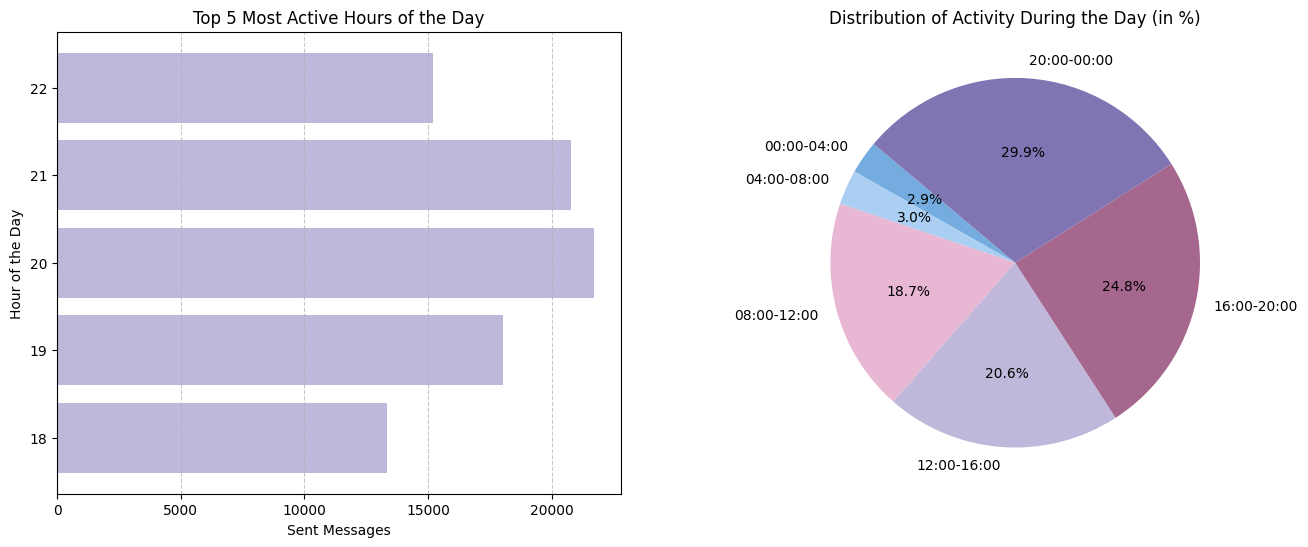

In [27]:
percentage = top_5_h['percent'].tolist()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].barh(top_5_h['hour'], top_5_h['message_count'], color='#bfb8da')
axs[0].set_xlabel('Sent Messages')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Top 5 Most Active Hours of the Day')
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

axs[1].pie(msg_h_range['message_count'], labels=msg_h_range['hour_range'],
       autopct='%1.1f%%', startangle=140, colors=colors)
axs[1].set_title('Distribution of Activity During the Day (in %)')

plt.show()

1 plot:
- 100% - all messages sent
- on the plot there's percentage of messages sent during each hour of all messages sent

On this graphs we can see what hours do I send the most messages and distribution of basic time ranges to see what time of the day usually I'm more active. \

During the day there's +/- same activity (18-25%) \
and closer to night (20:00-00:00) I show the highest acivity when I send the most messages, specificaly at 20:00-22:00.

### hours of sleep

In [28]:
sleep_h = prs_s_h.drop(['hour_range'], axis=1)
sleep_h = sleep_h.nsmallest(9, 'message_count')

sleep_h['percent'] = (sleep_h['message_count'] / total) * 100
sleep_h['percent'] = sleep_h['percent'].apply(lambda x: f"{x:.2f}%")

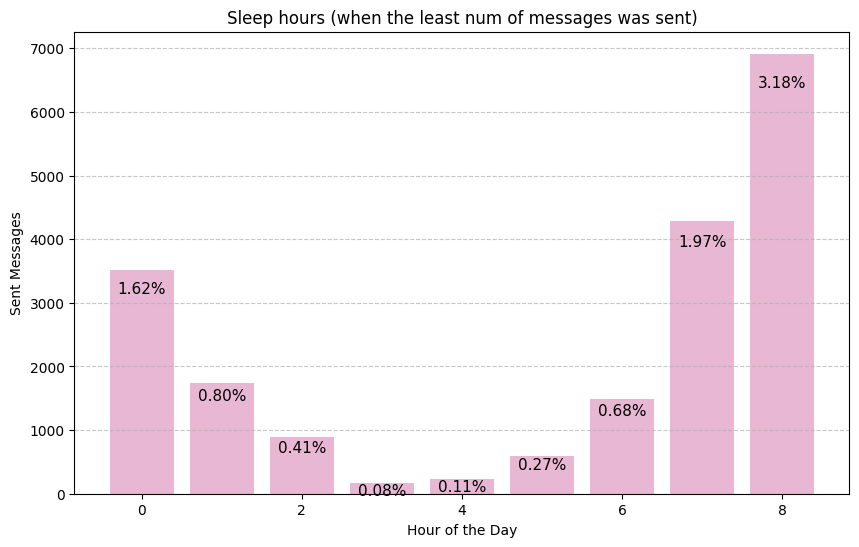

In [29]:
percentage = sleep_h['percent'].tolist()

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(sleep_h['hour'], sleep_h['message_count'], color='#e8b7d4')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Sent Messages')
ax.set_title('Sleep hours (when the least num of messages was sent)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, percent in zip(ax.patches, percentage):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 0.05 * bar.get_height(), percent,
        ha='center', va='top', fontsize=11)

plt.show()

here's the same thing as on the previous plot:
- 100% - all messages sent
- on the plot there's percentage of messages sent during each hour of all messages sent

That's pretty accurate, cause I do go to sleep at ~1 am and wake up at 8-9 am

### top 10 people whose messages were forwarded most

In [30]:
def extract_id(id):
  if isinstance(id, str):
    if 'PeerChat' in id:
      match = re.search(r'chat_id=(\d+)', id)
      if match:
        return int(match.group(1))
    elif 'PeerChannel' in id:
      match = re.search(r'channel_id=(\d+)', id)
      if match:
        return int(match.group(1))
    elif 'PeerUser' in id:
      match = re.search(r'user_id=(\d+)', id)
      if match:
        return int(match.group(1))

  return id

In [31]:
df['fwd_id'] = df['fwd_from'].apply(extract_id)

In [32]:
def convert_to_int(val):
  if pd.isna(val):
    return np.nan
  try:
    return int(float(val))
  except (ValueError, TypeError):
    return val

In [33]:
df['fwd_id'] = df['fwd_id'].apply(convert_to_int)

In [34]:
fwd_msg = df[df['fwd_from'].notna()]

- checking if new column ids match the original ones

- defining user names and choosing top 10

In [38]:
fwd_by_id = fwd_msg.groupby('fwd_id').size()
df_fwd_by_id = fwd_by_id.reset_index()
df_fwd_by_id.columns = ['dialog_id', 'message_count']

# merging dfs to find out the name of each user
df_fwd_by_id = df_fwd_by_id.merge(df_meta[['dialog_id', 'full_name']], on='dialog_id', how='left')
# full name as index and dropping useless columns
df_fwd_by_id = df_fwd_by_id.set_index('full_name').drop(columns=['dialog_id'])

df_fwd_by_id = df_fwd_by_id.reset_index()
df_fwd_by_id.columns = ['full_name', 'message_count']
df_fwd_by_id = df_fwd_by_id[df_fwd_by_id['full_name'].notna()]

In [39]:
# top 10 people
top_10_fwd = df_fwd_by_id.nlargest(10, 'message_count')
top_10_fwd = top_10_fwd.set_index('full_name')
top_10_fwd

,message_count
full_name,
оля (микитенко),3309
маша,2414
марина,521
Tripp ♨ 🦴,229
Оленка 🐒,164
гайвак,141
Аліна Ємець,129
лариса василенко,128
Oleksiy Kashpirovskiy,127


### distribution of forwarded messages

In [40]:
fwd_m = fwd_msg.groupby('month').size()
fwd_m.index = fwd_m.index.to_timestamp()

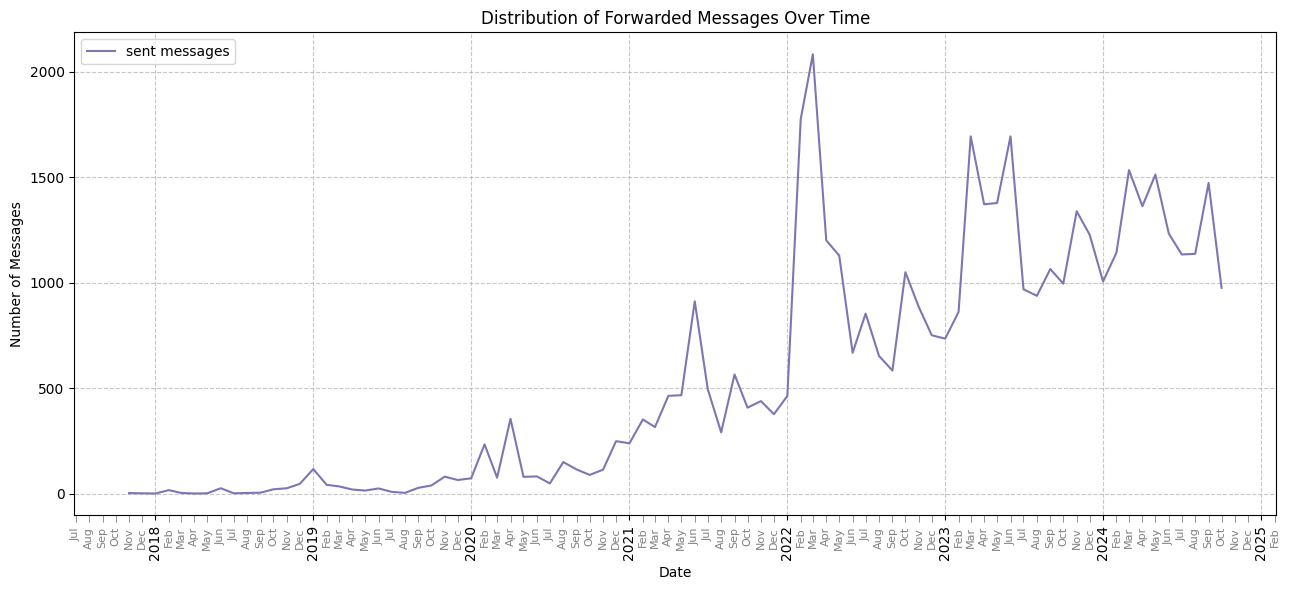

In [41]:
plt.figure(figsize=(13, 6))

plt.plot(fwd_m.index, fwd_m.values,
         label='sent messages', color='#8174b3')
ax = plt.gca()

# year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# month
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.tick_params(axis='x', which='minor', length=5, color='gray',
                labelsize=8, labelcolor='gray', rotation=90)
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.title('Distribution of Forwarded Messages Over Time')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### types of forwarded messages

Text(0.5, 1.0, 'Total Amount of Forwarded Messages of Each Type')

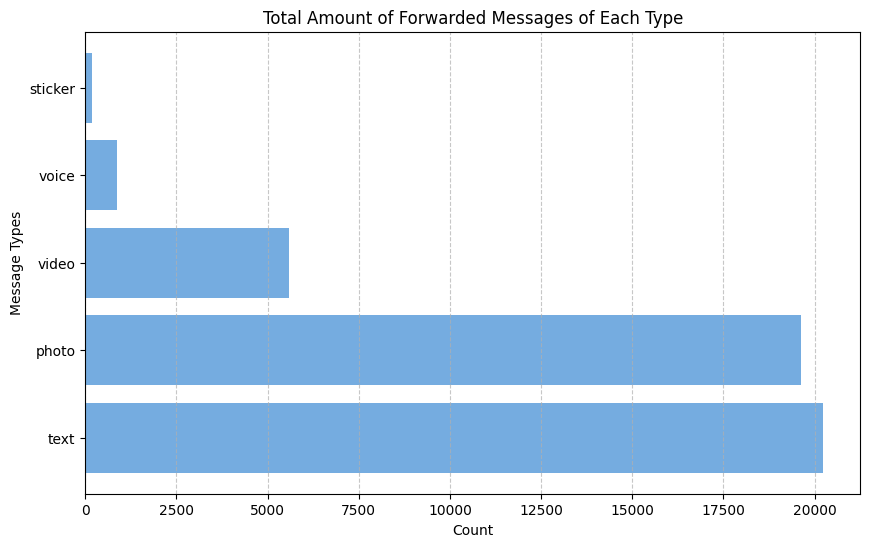

In [42]:
types = fwd_msg['type'].value_counts()
df_types = types.reset_index()
df_types.columns = ['type', 'count']

plt.figure(figsize=(10, 6))
plt.barh(df_types['type'], df_types['count'], color='#75ace0')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Count')
plt.ylabel('Message Types')
plt.title('Total Amount of Forwarded Messages of Each Type')

### people I texted to the most at the begining of full-scale invasion

- I chose all messages during the first month

In [43]:
start_date = '2022-02-24'
end_date = '2022-3-24'

fullsc = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [47]:
prs_id = df_meta[df_meta['type'] == 'Private dialog']['dialog_id']

prs_sent_fs = fullsc[(fullsc['from_id'] == my_id) & (fullsc['dialog_id'].isin(prs_id))]

In [48]:
# counting sent messages for each user and picking 5 largest values
sent_by_people = prs_sent_fs.groupby('to_id').size()
df_sent_by_people = sent_by_people.reset_index()
df_sent_by_people.columns = ['user_id', 'message_count']
top_5_s = df_sent_by_people.nlargest(6, 'message_count')
# merging dfs to find out the name of each user
df_meta = df_meta.rename(columns={'dialog_id': 'user_id'})
top_5_s = top_5_s.merge(df_meta[['user_id', 'full_name']], on='user_id', how='left')
# full name as index and dropping useless columns
top_5_s = top_5_s[top_5_s['full_name'].notna()]
top_10_s = top_5_s.set_index('full_name').drop(columns=['user_id'])
top_10_s

,message_count
full_name,
папа ❤️,185
кльоцка,168
маша stouhx,148
лера недайбіда,141
льоша бевза,31


### number of private messages I received on different types of holidays

I chose 3 types of holidays: my birthday, new year, 8th of march

In [49]:
# messages i personaly received
prs_rcv = df[(df['to_id'] == my_id) & (df['dialog_id'].isin(prs_id))]

- my birthday

In [50]:
bday_df = prs_rcv[(prs_rcv['date'].dt.month == 10) & (prs_rcv['date'].dt.day == 5)]
bday_num = bday_df.count().iloc[0]

- new year

In [51]:
ny_df = prs_rcv[(prs_rcv['date'].dt.month == 12) & (prs_rcv['date'].dt.day == 31)]
ny_num = ny_df.count().iloc[0]

- 8th of march

In [52]:
mar_df = prs_rcv[(prs_rcv['date'].dt.month == 3) & (prs_rcv['date'].dt.day == 8)]
mar_num = mar_df.count().iloc[0]

- results

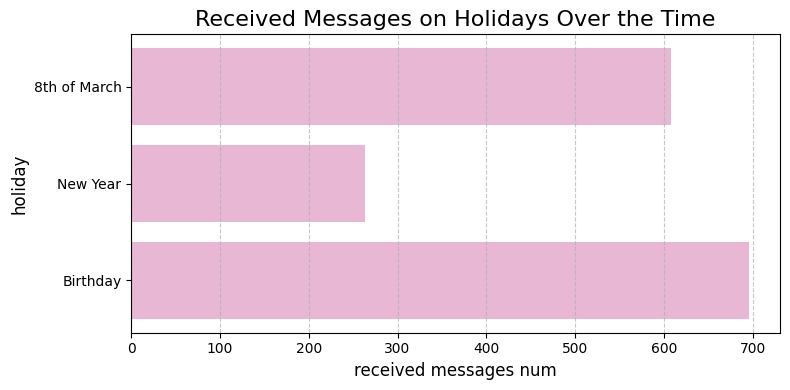

In [53]:
labels = ['Birthday', 'New Year', '8th of March']
values = [bday_num, ny_num, mar_num]

plt.figure(figsize=(8, 4))
plt.barh(labels, values, color='#e8b7d4')
plt.title('Received Messages on Holidays Over the Time', fontsize=16)
plt.xlabel('received messages num', fontsize=12)
plt.ylabel('holiday', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Seems like people celebrate my birthday more often than new year

### changes in my activity depending on year season

In [54]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

In [55]:
prs_sent['season'] = prs_sent['date'].apply(get_season)
season_act = prs_sent.groupby(['year', 'season']).size().reset_index(name='activity')

<ipython-input-55-3eeedbd532d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prs_sent['season'] = prs_sent['date'].apply(get_season)


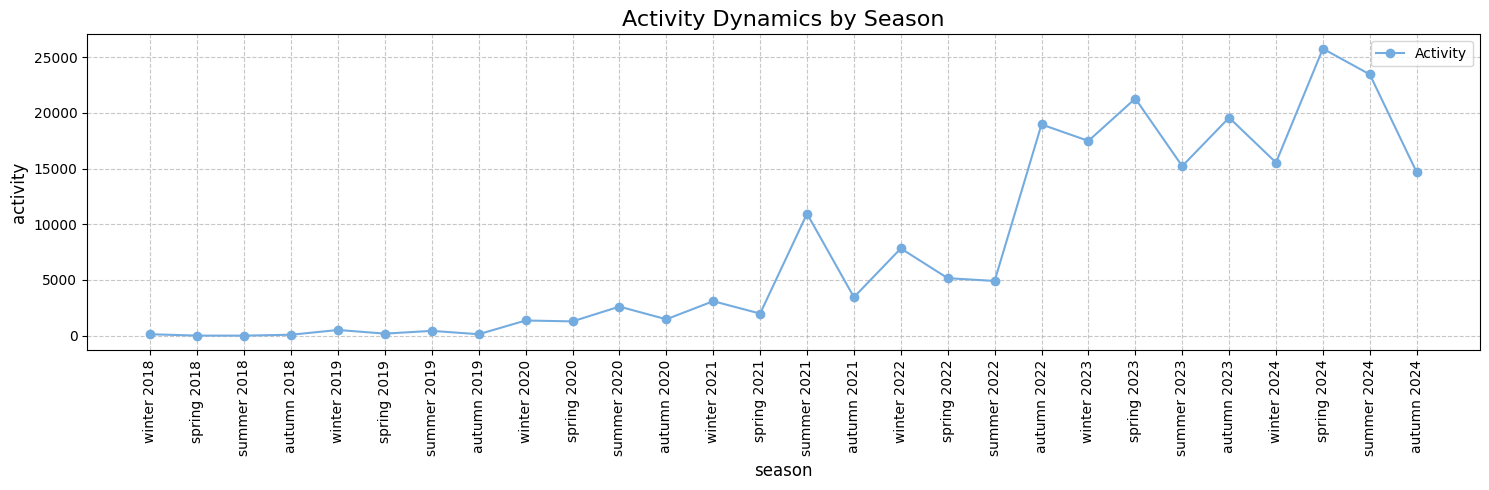

In [56]:
season_order = ['winter', 'spring', 'summer', 'autumn']
season_act['season'] = pd.Categorical(season_act['season'], categories=season_order, ordered=True)
season_sorted = season_act.sort_values(['year', 'season'])

season_sorted['season_year'] = season_sorted['season'].astype(str) + ' ' + season_sorted['year'].astype(str)

plt.figure(figsize=(15, 5))
plt.plot(season_sorted['season_year'], season_sorted['activity'], marker='o', color='#75ace0', label='Activity')

plt.xticks(rotation=90, fontsize=10)
plt.title('Activity Dynamics by Season', fontsize=16)
plt.xlabel('season', fontsize=12)
plt.ylabel('activity', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

As we can see, usually in autumn and spring activity goes up.\
Basically It's because the academic year begins in autumn and in spring it's the end of the course and there're lots of exams.\
One of the highest dots's on autumn 2022, when i entered the university and since then my activity highly increased probably because most of the education i got online so i use telegram to communicate with students, lectors ect.


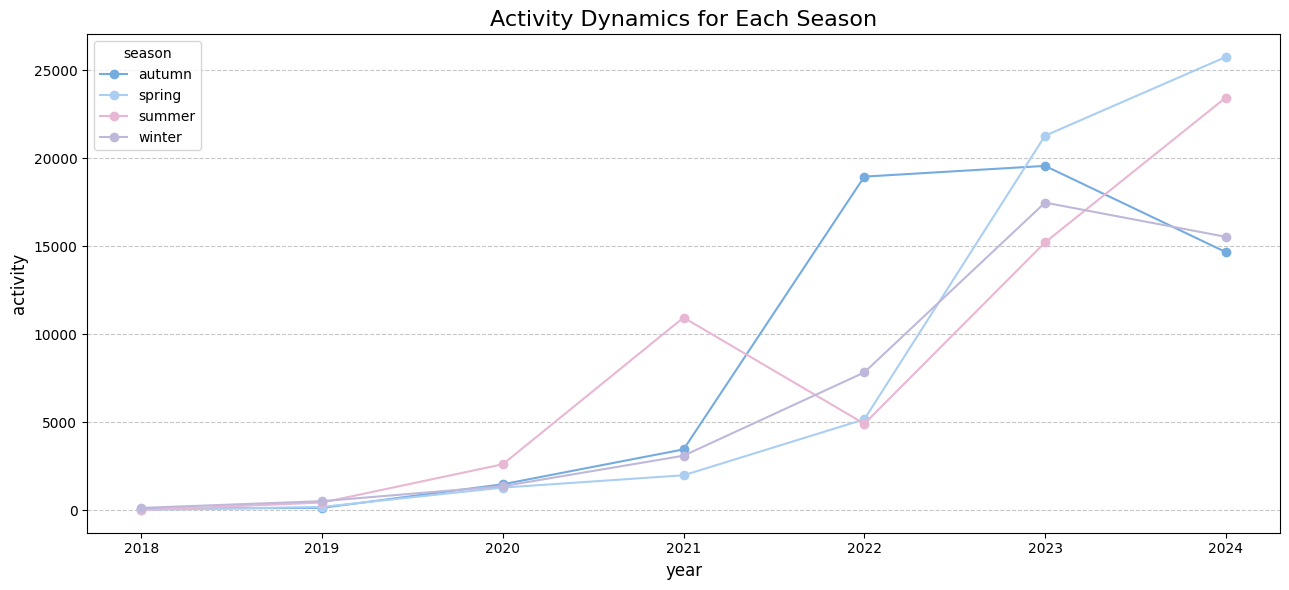

In [57]:
plt.figure(figsize=(13, 6))

for idx, season in enumerate(season_act['season'].unique()):
    season_data = season_act[season_act['season'] == season]
    plt.plot(season_data['year'], season_data['activity'],
             label=season, marker='o', color=colors[idx % len(colors)])

plt.title('Activity Dynamics for Each Season', fontsize=16)
plt.xlabel('year', fontsize=12)
plt.ylabel('activity', fontsize=12)
plt.legend(title='season')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### changes in my activity during exams period

In [63]:
unitime_df = prs_sent[
    (prs_sent['date'].dt.year.isin([2022, 2023, 2024])) &
    ((prs_sent['date'].dt.month >= 9) | (prs_sent['date'].dt.month <= 6))]

In [64]:
unitime_by_month = unitime_df.groupby('month').size()
unitime_by_month.index = unitime_by_month.index.to_timestamp()

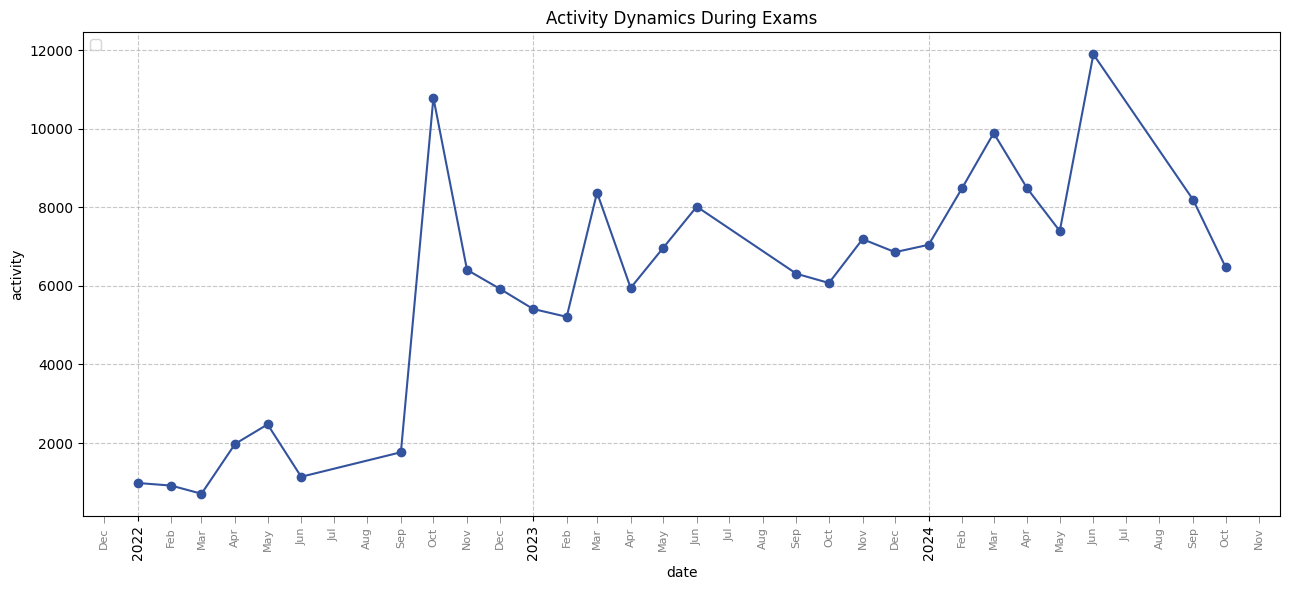

In [65]:
plt.figure(figsize=(13, 6))

plt.plot(unitime_by_month.index, unitime_by_month.values,
         marker='o', color='#33539e')

ax = plt.gca()

# year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# month
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.tick_params(axis='x', which='minor', length=5, color='gray',
                labelsize=8, labelcolor='gray', rotation=90)
plt.xlabel('date')
plt.ylabel('activity')
plt.title('Activity Dynamics During Exams')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

First of all we can see how line goes up the same way as in previous analysis, in october 2022,\
when I entered the university and was also added to "Chat FI".\
Here're some other patterns:
- activity increases every february, it's because 2 semester of academic year begins at that time
- less activity in december-january during holidays
- higher activity in june - exams!
- a bit higher activity on november also because of exams probably, but actually i thought it would be higher

### number of people who hide/unhide their phone number

In [66]:
# extracting phone number
def extract_phone(text):
    match = re.search(r"'phone': '(\d+)'", text)
    if match:
      return match.group(1)
    else:
      return None

In [67]:
df_meta['users'] = df_meta['users'].astype(str)

In [68]:
df_meta['phone'] = df_meta['users'].apply(extract_phone)
df_meta['phone'] = df_meta['phone'].astype(str)

In [69]:
# not working with channels
prv_meta = df_meta[df_meta['type'] != 'Channel']

In [70]:
phones_df = prv_meta[prv_meta['phone'] != 'None']
phones_nan = prv_meta[prv_meta['phone'] == 'None']

In [71]:
phones_df_num = phones_df['phone'].nunique()
phones_nan_num = phones_nan.count().iloc[0]

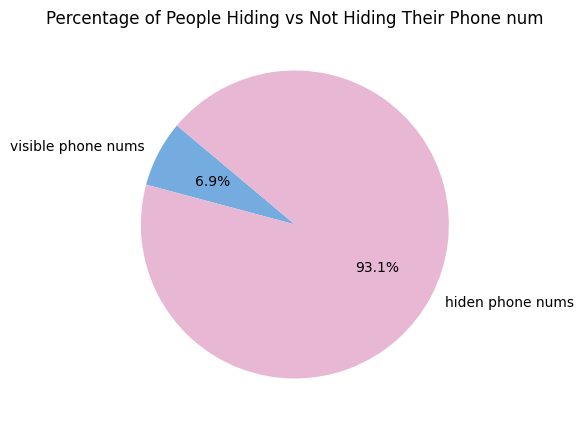

In [77]:
labels = ['visible phone nums', 'hiden phone nums']
sizes = [phones_df_num, phones_nan_num]
clr = ['#75ace0', '#e8b7d4']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=clr)
plt.title('Percentage of People Hiding vs Not Hiding Their Phone num')
plt.show()

Happy to see that most people care about their safety!\
I guess actual percent of people who don't hide their num is much smaller,\
cause this distribution also includes people from my contacts who share their phone number specificaly with me.

### most common emojis in messages

In [78]:
def extract_emojis(text):
    if not isinstance(text, str):
        return []
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

In [79]:
df['emojis'] = df['message'].apply(lambda x: ', '.join(extract_emojis(x)))
df_expl = df['emojis'].str.split(', ').explode()

df_expl = df_expl.dropna().str.strip()
df_expl = df_expl[df_expl != '']

In [80]:
em_count = df_expl.value_counts()
em_count.head(6)

,count
emojis,
🛑,12849
❗️,11589
🔹,11094
👉🏻,7303
💬,6970
⚡️,6415


I thought it would be more fun to show most common emojis, but apparently all top emojis are those which are used by news' channels,\
so let's make same research on private dialogs.

In [81]:
# all personal chats
prs_chats = df[df['dialog_id'].isin(prs_id)]

In [82]:
df_prs_chats = prs_chats['emojis'].str.split(', ').explode()

df_prs_chats = df_prs_chats.dropna().str.strip()
df_prs_chats = df_prs_chats[df_prs_chats != '']

In [83]:
prs_em_count = df_prs_chats.value_counts()
prs_em_count.head(6)

,count
emojis,
❤️,1024
😂,968
😭,855
😎,459
👍,449
😊,405


much cooler now 😎👍

### most common reactions

In [84]:
def extract_emojis_2(text):
    if isinstance(text, str):
        matches = re.findall(r"'(.*?)'", text)
        return ','.join(matches) if matches else None
    return None

In [85]:
df['react_emj'] = df['reactions'].apply(extract_emojis_2)

In [86]:
df_exploded = df['react_emj'].dropna().str.replace(' ', '').str.split(',').explode()
emoji_counts = df_exploded.value_counts()

emoji_counts.head(5)

,count
react_emj,
❤,103328
👍,40385
😁,12112
😭,8809
🔥,7847


It seems like there's always some sad news.. Let's try to analyse private chats

In [87]:
# to make sure prs_chats also contains cleaned reactions
prs_chats = df[df['dialog_id'].isin(prs_id)]

In [89]:
prs_exploded = prs_chats['react_emj'].dropna().str.replace(' ', '').str.split(',').explode()
prs_em_counts = prs_exploded.value_counts()

prs_em_counts.head(5)

,count
react_emj,
❤,42189
👍,4484
😁,796
😭,729
🙏,509


Well, the result's almoust the same, but '🙏' makes me feel a bit more calm

### df & df_meta merge

I dowloaded csv of df_meta with full list of users for each row(prv dialog, group, channel)\
It's important for proper merge

In [99]:
df_meta_path_2 = "/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data_upd/df_meta_upd_2.csv"

In [100]:
df_meta_2 = pd.read_csv(df_meta_path_2)

In [101]:
df_meta_2.loc[df_meta_2['type'] != 'Private dialog', 'full_name'] = np.nan

In [102]:
df_meta_2 = df_meta_2.drop('Unnamed: 0', axis=1)

In [103]:
df_meta_2.rename(columns={'id': 'dialog_id'}, inplace=True)

In [105]:
df_meta_2.dtypes

,0
dialog_id,int64
name,object
type,object
users,object
full_name,object


cool, now we can merge dataframes

In [106]:
mdf = df.merge(df_meta_2, on='dialog_id', how='left')

In [107]:
mdf.rename(columns={'type_x': 'type_msg'}, inplace=True)
mdf.rename(columns={'type_y': 'type_dl'}, inplace=True)

In [108]:
mdf.columns

Index(['id', 'date', 'from_id', 'to_id', 'fwd_from', 'message', 'type_msg',
       'duration', 'reactions', 'dialog_id', 'day', 'week_day', 'hour',
       'month', 'year', 'fwd_id', 'emojis', 'react_emj', 'name', 'type_dl',
       'users', 'full_name'],
      dtype='object')

done! let's get back to analysis

### which news channels my mom reads most (depending on her forwarded messages)

In [110]:
m_df = mdf[mdf['dialog_id'] == mom_id]

In [111]:
# working only with received messages
m_df = m_df[m_df['to_id'] == my_id]

In [112]:
m_df = m_df[m_df['message'].notna()]

In [113]:
# picking messages starting from 24.02.2022
start_date = '2022-02-24'
m_df = m_df[(m_df['date'] >= start_date)]

In [114]:
m_gr = m_df.groupby('fwd_id').size()
m_gr = m_gr.reset_index()
m_gr.columns = ['fwd_id', 'message_count']

In [115]:
m_5 = m_gr.nlargest(5, 'message_count')

In [116]:
id_to_name = {
    1409920010: "Київ | Times",
    1149787308: "Інсайдер Київ",
    1459014436: "@smolii_ukraine",
    1281716156: "Ми з Києва",
    1210003725: "Киевский Движ"}

In [117]:
m_5['name'] = m_5['fwd_id'].map(id_to_name)

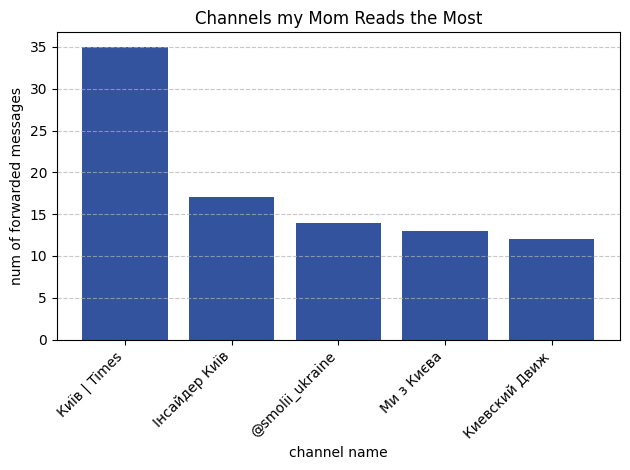

In [303]:
plt.bar(m_5['name'], m_5['message_count'], color='#33539e')
plt.xlabel('channel name')
plt.ylabel('num of forwarded messages')
plt.title('Channels my Mom Reads the Most')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### average duration of the conversation

In [121]:
prv_df = mdf[mdf['type_dl'] == 'Private dialog']

In [122]:
prv_df = prv_df.sort_values(by=['id', 'date']).reset_index(drop=True)
prv_df['time_diff'] = prv_df['date'].diff().dt.total_seconds()

In [123]:
# if difference between time-sent is more than 7 min - it's a new convo
prv_df['new_convo'] = prv_df['time_diff'] > 420

prv_df['convo_id'] = prv_df['new_convo'].cumsum()

In [124]:
convo_dur = prv_df.groupby('convo_id').agg(
    start_time=('date', 'min'),
    end_time=('date', 'max'))

convo_dur['dur_sec'] = (convo_dur['end_time'] - convo_dur['start_time']).dt.total_seconds()
convo_dur['dur_min'] = round(convo_dur['dur_sec'] / 60)

In [125]:
avg_dur = convo_dur['dur_min'].mean()

In [126]:
print(f'Average duration of the conversation: {round(avg_dur)} minutes')

Average duration of the conversation: 6 minutes


## natural language proccessing

### cleaning the data

In [127]:
mdf['message'] = mdf['message'].astype(str)

- removing punctuation marks and numbers

In [129]:
def clean_text(text):
    if pd.isnull(text):
        return None
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    return text

In [130]:
mdf['clean_msg'] = mdf['message'].apply(clean_text)

In [131]:
mdf['clean_msg'].head()

,clean_msg
0,ytbaudiobot
1,ytbaudiobot
2,дааа ахуєнна
3,хахахаххаха сука
4,тут треки дуже різні по характеру


- tokenization

In [132]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [133]:
mdf['tokens'] = mdf['clean_msg'].apply(word_tokenize)

In [134]:
mdf['tokens'] = mdf['tokens'].apply(lambda x: [item for item in x if item != 'nan'] if isinstance(x, list) else x)

In [135]:
mdf['tokens'] = mdf['tokens'].apply(lambda x: [item for item in x if item != 'sticker'] if isinstance(x, list) else x)

In [136]:
mdf['tokens'].head()

,tokens
0,[ytbaudiobot]
1,[ytbaudiobot]
2,"[дааа, ахуєнна]"
3,"[хахахаххаха, сука]"
4,"[тут, треки, дуже, різні, по, характеру]"


### length of message analysis

Before continuing preparing the data i wanna do some analysis

- sent messages

In [137]:
mdf_sent = mdf[(mdf['from_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]
mdf_rcv = mdf[(mdf['to_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]

In [138]:
mdf_sent['msg_lgth'] = mdf_sent['tokens'].apply(len)
avg_lgth_s = mdf_sent['msg_lgth'].mean()
max_lgth_s = mdf_sent['msg_lgth'].max()

<ipython-input-138-0f1d51710db2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_sent['msg_lgth'] = mdf_sent['tokens'].apply(len)


- received messages

In [139]:
mdf_rcv['msg_lgth'] = mdf_rcv['tokens'].apply(len)
avg_lgth_r = mdf_rcv['msg_lgth'].mean()
max_lgth_r = mdf_rcv['msg_lgth'].max()

<ipython-input-139-a7a888623991>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_rcv['msg_lgth'] = mdf_rcv['tokens'].apply(len)


- results

In [140]:
print('Sent messages:')
print(f'Average length of message: {round(avg_lgth_s, 2)}')
print(f'Maximum length of message: {max_lgth_s}\n')
print('Received messages:')
print(f'Average length of message: {round(avg_lgth_r, 2)}')
print(f'Maximum length of message: {max_lgth_r}')

Sent messages:
Average length of message: 4.65
Maximum length of message: 647

Received messages:
Average length of message: 4.53
Maximum length of message: 647


i didn't round average legth to 5, so you can see that there's a bit different results, but basically average legth of message is 5 words\
\
the same result for maximum length is because telegram already have limit for message length

### deleting stopwords

*stopwords_ua source: [https://github.com/skupriienko/Ukrainian-Stopwords/tree/master](https://github.com/skupriienko/Ukrainian-Stopwords/tree/master)*

In [141]:
stopwords_ua = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data/stopwords_ua.txt", header=None, names=['stopwords'])
stop_words_ukr = list(stopwords_ua.stopwords)
print(stop_words_ukr[:5])

['а', 'аби', 'абиде', 'абиким', 'абикого']


In [142]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [143]:
stop_words_ua = set(stop_words_ukr)
stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))

In [144]:
all_stopwords = stop_words_en | stop_words_ru | stop_words_ua

In [145]:
mdf['tokens'] = mdf['tokens'].apply(lambda x: [word for word in x if word not in all_stopwords])

In [146]:
mdf['tokens'] = mdf['tokens'].apply(lambda x: [word for word in x if word != 'ласка'])

In [147]:
mdf['tokens'].head(10)

,tokens
0,[ytbaudiobot]
1,[ytbaudiobot]
2,"[дааа, ахуєнна]"
3,"[хахахаххаха, сука]"
4,"[треки, різні, характеру]"
5,[щас]
6,[послухай]
7,[ахахаххахаха]
8,"[хахахаххаа, сука, ввімкнулось]"
9,[ytbaudiobot]


### most common words

before doing lemmatization, i decided to do some analysis so in results words and phrases will be more understandable and make more sense

- sent messages

In [148]:
mdf_sent = mdf[(mdf['from_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]

In [149]:
all_tokens_s = [token for tokens in mdf_sent['tokens'] for token in tokens]
word_freq_s = Counter(all_tokens_s)

In [150]:
common_words_s = word_freq_s.most_common(10)
words_s, counts_s = zip(*common_words_s)

- received messages

In [151]:
mdf_rcv = mdf[(mdf['to_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]

In [152]:
all_tokens_r = [token for tokens in mdf_rcv['tokens'] for token in tokens]
word_freq_r = Counter(all_tokens_r)

In [153]:
common_words_r = word_freq_r.most_common(10)
words_r, counts_r = zip(*common_words_r)

- results!

<ipython-input-164-fece83d22635>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words_s, rotation=45)
<ipython-input-164-fece83d22635>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(words_r, rotation=45)


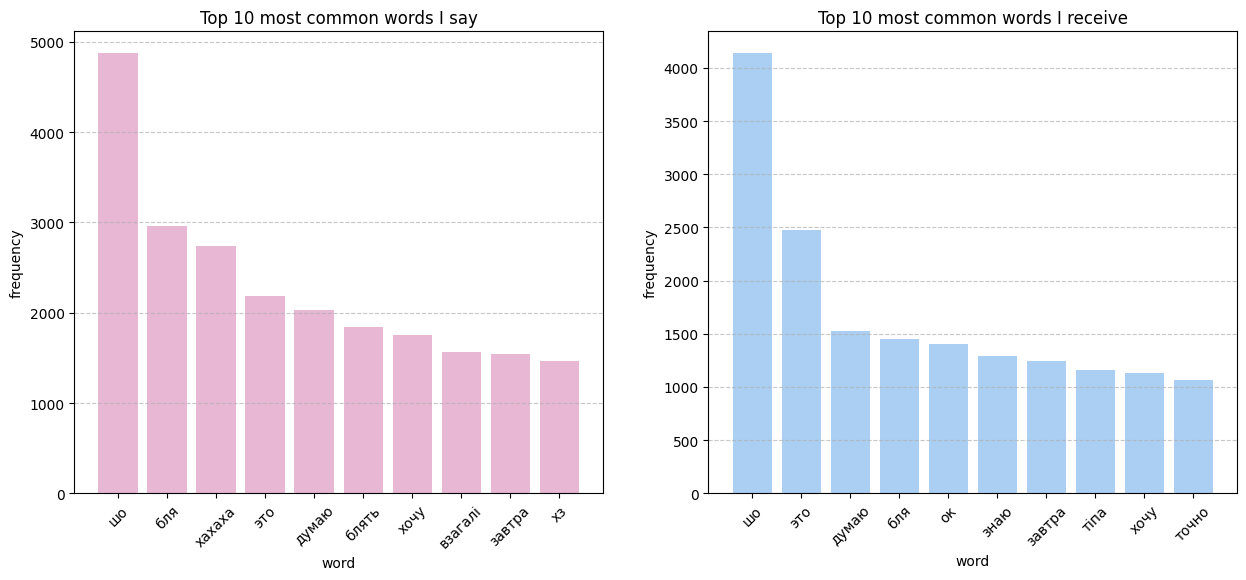

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# sent
axes[0].bar(words_s, counts_s, color='#e8b7d4')
axes[0].set_title('Top 10 most common words I say')
axes[0].set_xlabel('word')
axes[0].set_ylabel('frequency')
axes[0].set_xticklabels(words_s, rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# received
axes[1].bar(words_r, counts_r, color='#aacff2')
axes[1].set_title('Top 10 most common words I receive')
axes[1].set_xlabel('word')
axes[1].set_ylabel('frequency')
axes[1].set_xticklabels(words_r, rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### most common phrases

In [165]:
def generate_ngrams(tokens, n):
    return zip(*[tokens[i:] for i in range(n)])

- sent

In [166]:
phrases_s = []
n = 2  # 2-words phrases
for t in mdf_sent['tokens']:
    phrases_s.extend(generate_ngrams(t, n))

In [167]:
phrase_counts_s = Counter(phrases_s)

In [168]:
top_5_ph_s = phrase_counts_s.most_common(5)

In [169]:
phrases_s = pd.DataFrame(
    [(pair[0][0], pair[0][1], pair[1]) for pair in top_5_ph_s],
    columns=['word1', 'word2', 'frequency']
)

In [170]:
phrases_s['phrase'] = phrases_s['word1'] + ' ' + phrases_s['word2']
phrases_s = phrases_s[['phrase', 'frequency']]

- received

before generatin n-gramms, i should prepare the data.\
there're lots of eng words from bots, so i decided to filter them.

In [171]:
# picking only cyrillic tokens
def is_cyrillic_simple(word):
    return all('\u0400' <= char <= '\u04FF' for char in word)

def filter_cyrillic(tokens):
    return [token for token in tokens if is_cyrillic_simple(token)]

In [172]:
mdf_rcv['tokens'] = mdf_rcv['tokens'].apply(filter_cyrillic)

<ipython-input-172-521fb31169b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_rcv['tokens'] = mdf_rcv['tokens'].apply(filter_cyrillic)


In [173]:
mdf_rcv1 = mdf_rcv.dropna(subset=['tokens'])

In [174]:
mdf_rcv1['tokens'] = mdf_rcv1['tokens'].apply(lambda x: [item for item in x if item != 'nan'] if isinstance(x, list) else x)

done!

In [175]:
phrases_r = []
n = 2  # 2-words phrases
for t in mdf_rcv1['tokens']:
    phrases_r.extend(generate_ngrams(t, n))

In [176]:
phrase_counts_r = Counter(phrases_r)

In [177]:
top_5_ph_r = phrase_counts_r.most_common(5)

In [178]:
phrases_r = pd.DataFrame(
    [(pair[0][0], pair[0][1], pair[1]) for pair in top_5_ph_r],
    columns=['word1', 'word2', 'frequency'])

In [179]:
phrases_r['phrase'] = phrases_r['word1'] + ' ' + phrases_r['word2']
phrases_r = phrases_r[['phrase', 'frequency']]

- results!

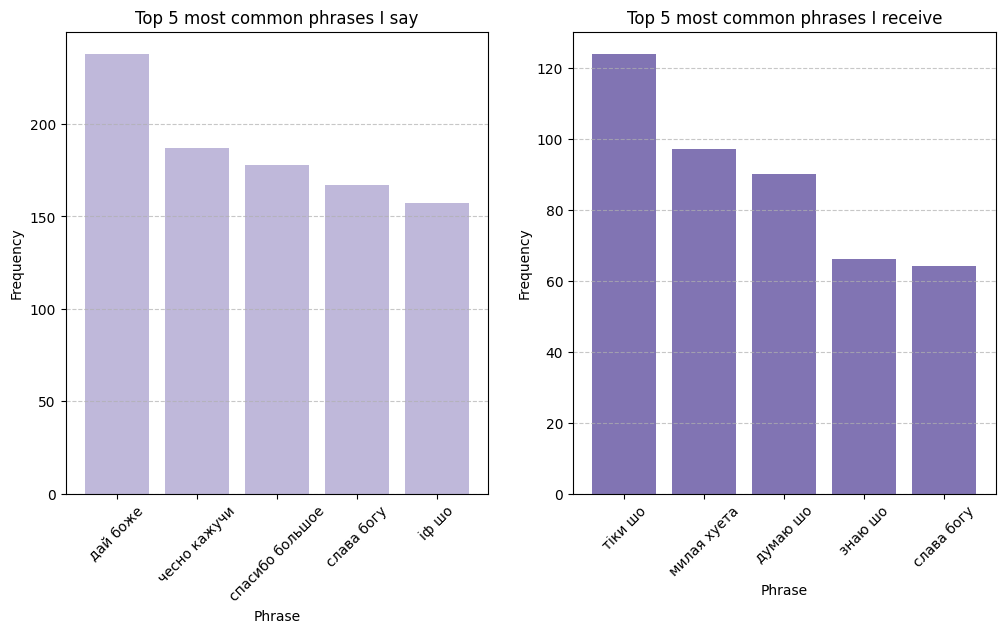

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# sent
axes[0].bar(phrases_s['phrase'], phrases_s['frequency'], color='#bfb8da')
axes[0].set_xticks(range(len(phrases_s['phrase'])))
axes[0].set_xticklabels(phrases_s['phrase'], rotation=45)
axes[0].set_xlabel('Phrase')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 5 most common phrases I say')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# received
axes[1].bar(phrases_r['phrase'], phrases_r['frequency'], color='#8174b3')
axes[1].set_xticks(range(len(phrases_r['phrase'])))
axes[1].set_xticklabels(phrases_r['phrase'], rotation=45)
axes[1].set_xlabel('Phrase')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 5 most common phrases I receive')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### lemmatization

*lemma-dicts source: [https://github.com/SanGreel/tone-dict-ukrainian](https://github.com/SanGreel/tone-dict-ukrainian)*

In [183]:
lem_dict_ua_pass = '/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data/dict_lemmatized_ua_words.json'
lem_dict_ru_pass = '/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data/dict_lemmatized_ru_words.json'

In [184]:
with open(lem_dict_ua_pass, 'r', encoding='utf-8') as f:
    lem_dict_ua = json.load(f)

with open(lem_dict_ru_pass, 'r', encoding='utf-8') as f:
    lem_dict_ru = json.load(f)

In [185]:
lem_dict = {**lem_dict_ua, **lem_dict_ru}

In [186]:
mdf['tokens'] = mdf['tokens'].apply(lambda words: [lem_dict.get(word, word) for word in words])

In [187]:
mdf['tokens'].head(7)

,tokens
0,[ytbaudiobot]
1,[ytbaudiobot]
2,"[дааа, ахуєнний]"
3,"[хахахаххаха, сук]"
4,"[трек, різний, характер]"
5,[щас]
6,[послухати]


done!

### tf-idf analisys

i decide to pick some timelines that seemed interesting to me

1. my course chat
- for the first month of studying - october 2022
- for the first exam period - december 2022

In [188]:
uni_df = mdf[mdf['dialog_id'] == course_chat_id]

In [189]:
uni_df = uni_df[uni_df['message'].notna()]

- first month of studying

In [190]:
start_date1 = '2022-10-01'
end_date1 = '2022-11-01'

uni_df1 = uni_df[(uni_df['date'] >= start_date1) & (uni_df['date'] <= end_date1)]

In [191]:
uni_df1.shape

(10922, 24)

In [192]:
uni_df1['text'] = uni_df1['tokens'].apply(lambda x: ' '.join(x))

<ipython-input-192-aed1dd54e2ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_df1['text'] = uni_df1['tokens'].apply(lambda x: ' '.join(x))


In [193]:
vectorizer = TfidfVectorizer()
matrix1 = vectorizer.fit_transform(uni_df1['text'])

In [194]:
tfidf1 = pd.DataFrame(
    matrix1.toarray(),
    columns=vectorizer.get_feature_names_out())

In [195]:
word_scores1 = tfidf1.sum(axis=0)

In [196]:
top_words1 = word_scores1.sort_values(ascending=False).head(10)

- exam period

In [197]:
start_date2 = '2022-12-01'
end_date2 = '2023-01-01'

uni_df2 = uni_df[(uni_df['date'] >= start_date2) & (uni_df['date'] <= end_date2)]

In [198]:
uni_df2.shape

(5934, 24)

In [199]:
uni_df2['text'] = uni_df2['tokens'].apply(lambda x: ' '.join(x))

<ipython-input-199-7e7099c2ccf1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_df2['text'] = uni_df2['tokens'].apply(lambda x: ' '.join(x))


In [200]:
matrix2 = vectorizer.fit_transform(uni_df2['text'])

In [201]:
tfidf2 = pd.DataFrame(
    matrix2.toarray(),
    columns=vectorizer.get_feature_names_out())

In [202]:
word_scores2 = tfidf2.sum(axis=0)

In [203]:
top_words2 = word_scores2.sort_values(ascending=False).head(10)

- results!

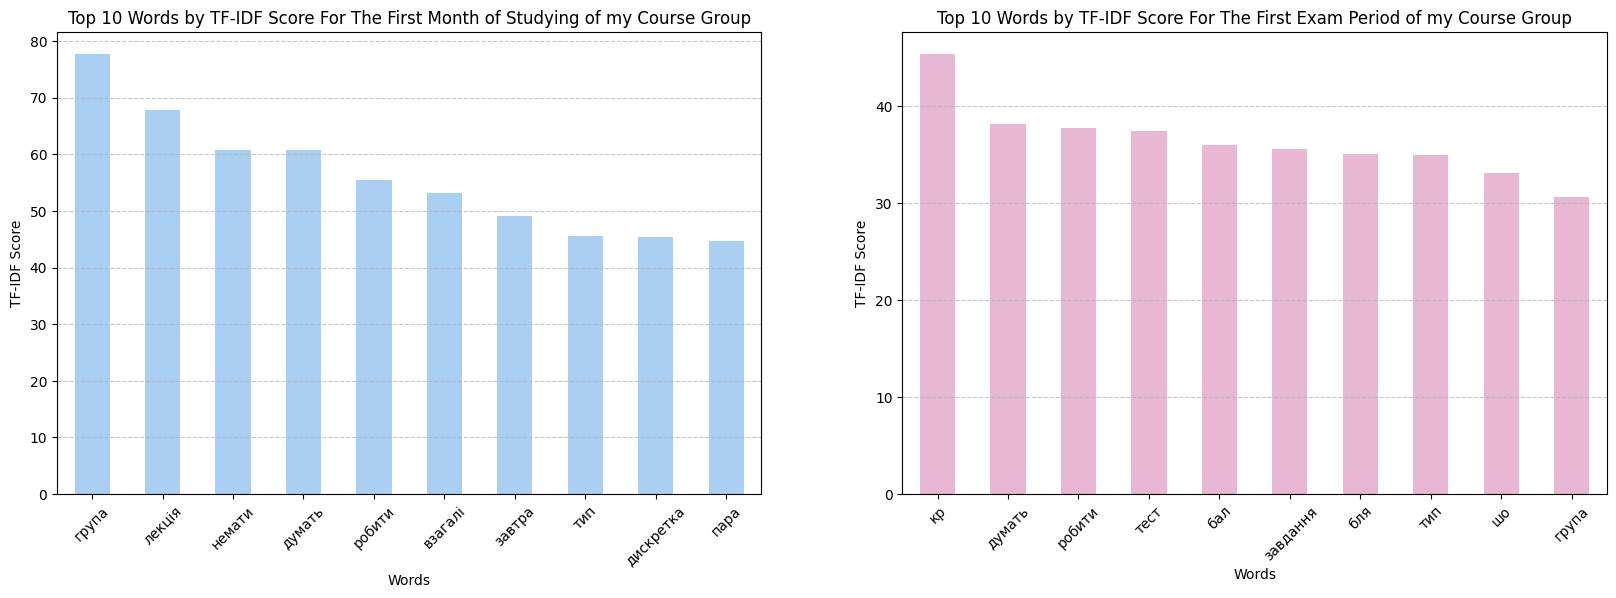

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# first month of studying
top_words1.plot(kind='bar', ax=axes[0], color='#aacff2')
axes[0].set_title('Top 10 Words by TF-IDF Score For The First Month of Studying of my Course Group')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('TF-IDF Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# first exam period
top_words2.plot(kind='bar', ax=axes[1], color='#e8b7d4')
axes[1].set_title('Top 10 Words by TF-IDF Score For The First Exam Period of my Course Group')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('TF-IDF Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### sentimental analysis

In [ ]:
analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def sentiment(tokens):
  text = " ".join(tokens)
  result = analyzer(text)[0]
  return result['label'], result['score']

- working with sent&received messages

In [ ]:
# making sure tokens are lemmatized here
mdf_sent = mdf[(mdf['from_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]
mdf_rcv = mdf[(mdf['to_id'] == my_id) & (mdf['dialog_id'].isin(prs_id))]

In [ ]:
stm_sent['sentiment'] = stm_sent['tokens'].apply(sentiment)

<ipython-input-257-0f56a7c832f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stm_sent['sentiment'] = stm_sent['tokens'].apply(sentiment)


In [ ]:
stm_sent['sentiment'].head()

,sentiment
155,"(negative, 0.3472995162010193)"
156,"(negative, 0.4306831955909729)"
157,"(neutral, 0.7519556879997253)"
158,"(neutral, 0.4683627784252167)"
160,"(negative, 0.3472995162010193)"


In [ ]:
stm_counts = stm_sent['sentiment'].value_counts()

In [ ]:
stm_sent['sentiment'] = stm_sent['sentiment'].astype(str)

<ipython-input-270-5a403261307f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stm_sent['sentiment'] = stm_sent['sentiment'].astype(str)


In [ ]:
stm_sent['score'] = stm_sent['sentiment'].apply(lambda x: float(re.search(r"([\d.]+)", x).group()))

<ipython-input-271-83b3e2f19d6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stm_sent['score'] = stm_sent['sentiment'].apply(lambda x: float(re.search(r"([\d.]+)", x).group()))


In [ ]:
stm_sent = stm_sent.sort_values(by='date')

In [ ]:
month_avg = stm_sent.groupby('month')['score'].mean().reset_index()
month_avg['month'] = month_avg['month'].dt.to_timestamp()

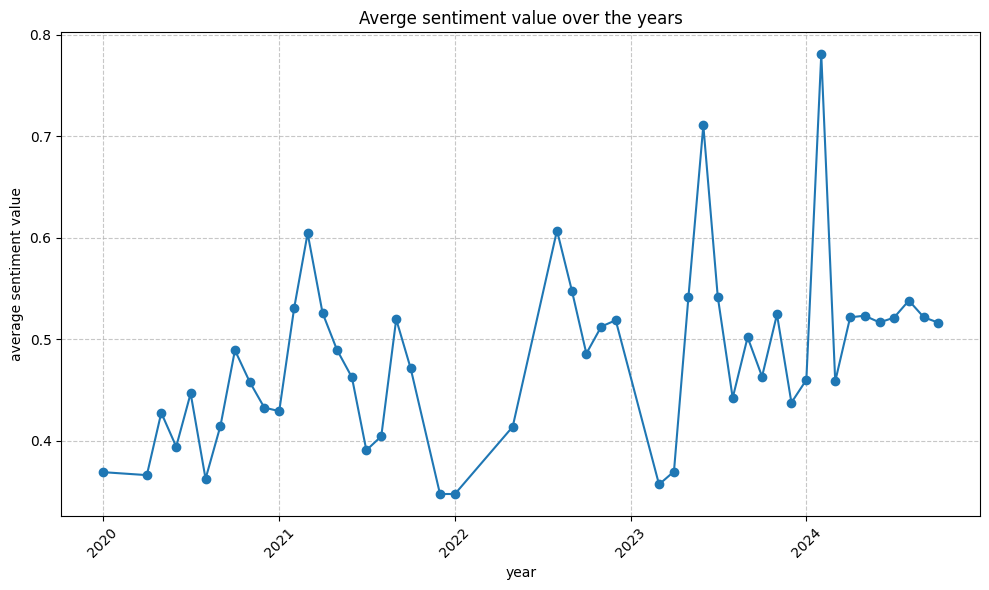

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(month_avg['month'], month_avg['score'], marker='o', linestyle='-')
plt.title('Averge sentiment value over the years')
plt.xlabel('year')
plt.ylabel('average sentiment value')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 1.0 - positive
- 0.5 - neutral
- 0.0 - negative

Some background: as we can see, beggining of 2022 was absolutely awful; entering the university made graph much better; at the beggining  of 2024 i went to a trip to my friends whom I haven't seen since the beginning of the war, and i was really exited; but mostly i have neutral mood

### most common cuss words

*cuss words dict source: [https://github.com/Behiwzad/swearify/tree/master](https://github.com/Behiwzad/swearify/tree/master)*

In [295]:
cw_list_pass = '/content/drive/MyDrive/Colab Notebooks/css/tg-data-analysis/data/words.json'

In [296]:
with open(cw_list_pass, 'r', encoding='utf-8') as f:
    cw_list = json.load(f)
    all_cw_list = cw_list['uk']

In [297]:
filt_cw = mdf_sent[mdf_sent['cuss_words'].notna()]

In [298]:
all_cw_s = [token for tokens in filt_cw['cuss_words'] for token in tokens]
cw_freq_s = Counter(all_cw_s)

In [299]:
cw_s = cw_freq_s.most_common(10)
cw_s, cw_counts_s = zip(*cw_s)

In [300]:
initial_count = dict(zip(cw_s, cw_counts_s))
keys_filt= [key for key in initial_count.keys()]
filt_dict = dict()
for key in keys_filt:
  if key in keys_filt:
    filt_dict[key] = initial_count[key]

In [301]:
filt_cw = pd.DataFrame(list(filt_dict.items()), columns=['word', 'count'])

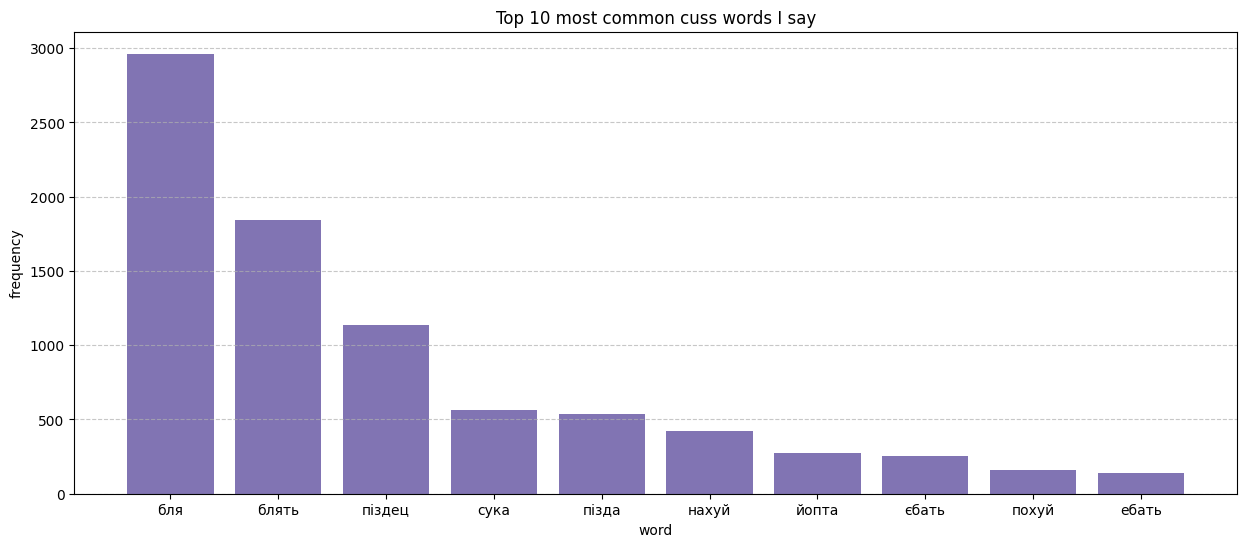

In [302]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.bar(filt_cw['word'], filt_cw['count'], color='#8174b3')
plt.title('Top 10 most common cuss words I say')
plt.xlabel('word')
plt.ylabel('frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I can confirm it's accurate

### conclusion on improvement of work

*here I wanna point out some things that i could improve or change*

- do some more sentimental analysis. i left it for the end, but it requires more time, maybe i should try different samples of data, not only for messages for the latest time
- i'd do a bit more analysis for convo duration, i think it could be interesting to dig deeper here
- there's obviously some better way to identify channels my mom reads without list
- maybe i should try a new lib for visualization
- in some analysis i could take more interesting samples of data
- i think i could try to filter my contacts, who share their phone number with me so the plot for this analysis would be more accurate
- i still want to do graph for people connections through groups, but i have no time for it

i think that's all what i wanted to add.
Thanks for attention!